<a href="https://colab.research.google.com/github/nancymahmoud1/Elevvo/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libraries
import kagglehub
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
# Set parameters
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

DATASET_PATH = os.path.join(path,"Data" , "genres_original")
SPECTROGRAM_PATH = os.path.join(path, "Data", "images_original")

IMG_SIZE = (128, 128)
GENRES = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()


100%|██████████| 1.21G/1.21G [00:05<00:00, 221MB/s]

Extracting files...


# Using Tabular features

In [4]:
# Step 1: Feature extraction (MFCCs, chroma, ZCR, tempo, etc.)
import librosa
import numpy as np

def extract_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=22050)
    features = {}

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        features[f"mfcc{i+1}_mean"] = np.mean(mfcc[i])
        features[f"mfcc{i+1}_std"] = np.std(mfcc[i])

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features["chroma_mean"] = np.mean(chroma)
    features["chroma_std"] = np.std(chroma)

    # Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features["zcr_mean"] = np.mean(zcr)

    # Spectral centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features["centroid_mean"] = np.mean(centroid)

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features["tempo"] = tempo

    return features


In [5]:
# Step 2 :Loop over dataset and create DataFrame
import pandas as pd
import os
import glob
from pathlib import Path

def build_dataset(data_root):
    data_root = Path(data_root)
    genres = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
    rows = []

    for genre in genres:
        files = glob.glob(str(data_root / genre / "*.wav"))
        print(f"Processing {genre}...")

        for file in files:
            try:
                feats = extract_features(file)
                feats["genre"] = genre
                rows.append(feats)
            except Exception as e:
                print(f"Error in {file}: {e}")

    return pd.DataFrame(rows)

df = build_dataset(DATASET_PATH)
df.to_csv("gtzan_features.csv", index=False)
df.head()


Processing blues...
Processing classical...
Processing country...
Processing disco...
Processing hiphop...
Processing jazz...


/tmp/ipython-input-601874564.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error in /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav: 
Processing metal...
Processing pop...
Processing reggae...
Processing rock...


,mfcc1_mean,mfcc1_std,mfcc2_mean,mfcc2_std,mfcc3_mean,mfcc3_std,mfcc4_mean,mfcc4_std,mfcc5_mean,mfcc5_std,...,mfcc19_mean,mfcc19_std,mfcc20_mean,mfcc20_std,chroma_mean,chroma_std,zcr_mean,centroid_mean,tempo,genre
0,-155.576401,55.472622,125.662727,28.312275,1.578583,22.211864,45.839695,18.814276,0.927781,16.199610,...,2.012547,8.266754,-5.731016,9.164933,0.336902,0.307767,0.050869,1441.680807,[172.265625],blues
1,-209.803925,44.369503,124.464760,23.279465,10.309394,25.732269,47.016357,12.182557,6.478227,10.094635,...,-1.767315,9.424652,-7.755139,10.669385,0.264910,0.301989,0.051402,1324.527825,[107.666015625],blues
2,-207.238297,67.644478,132.827408,25.807417,-15.454080,30.581554,60.980972,18.180555,0.719026,17.718584,...,-1.419384,10.610106,-5.933353,9.563502,0.269338,0.306433,0.069095,1360.685602,[184.5703125],blues
3,-130.578751,48.008705,139.961411,30.943388,-1.282277,23.143480,39.306229,13.141374,-6.344083,15.924735,...,-2.794982,7.183700,-6.488082,8.218748,0.369963,0.302133,0.057147,1388.632894,[135.99917763157896],blues
4,-236.305389,88.133194,161.680634,33.292404,-1.166163,24.673876,27.278690,10.781503,9.586513,18.233559,...,-2.416255,6.754847,-3.781820,6.343915,0.422259,0.304553,0.036052,991.486589,[63.02400914634146],blues


In [ ]:
# Step 3: Encode + Split + Scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

X = df.drop("genre", axis=1)
y = df["genre"]

# Encode genres
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [ ]:
# Step 4: Train classifier

from sklearn.svm import SVC

# Create and train the model
clf_svm = SVC(kernel="rbf", C=10, gamma="scale", probability=True, random_state=42)
clf_svm.fit(X_train, y_train)


SVC(C=10, probability=True, random_state=42)

SVM Accuracy: 0.765
              precision    recall  f1-score   support

       blues       0.64      0.70      0.67        20
   classical       0.90      0.95      0.93        20
     country       0.82      0.70      0.76        20
       disco       0.85      0.55      0.67        20
      hiphop       0.81      0.65      0.72        20
        jazz       0.75      0.90      0.82        20
       metal       0.83      0.75      0.79        20
         pop       0.76      0.95      0.84        20
      reggae       0.67      0.90      0.77        20
        rock       0.71      0.60      0.65        20

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.76       200



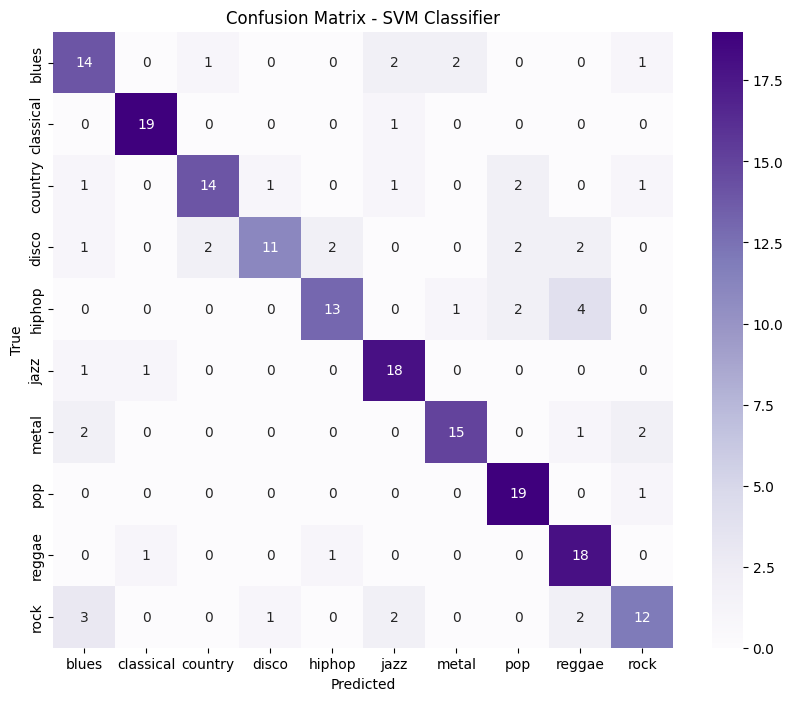

In [ ]:
# Step 5: Evaluate model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred_svm = clf_svm.predict(X_test)

# Accuracy
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Detailed report
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - SVM Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classify songs based on spectrogram features

# 1) **Custom** CNN model

In [6]:
# Step 1: Load image dataset
def load_dataset(img_dir):
    X, y = [], []
    for genre_idx, genre in enumerate(GENRES):
        genre_path = os.path.join(img_dir, genre)
        for img_file in os.listdir(genre_path):
            img_path = os.path.join(genre_path, img_file)
            img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
            X.append(np.array(img) / 255.0)
            y.append(genre_idx)
    return np.array(X), np.array(y)

X, y = load_dataset(SPECTROGRAM_PATH)


In [7]:
# Step 2: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Step 3: Build custom CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # 10 genres
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Step 4: Train model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 631ms/step - accuracy: 0.0958 - loss: 2.5356 - val_accuracy: 0.1350 - val_loss: 2.2456
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 641ms/step - accuracy: 0.2152 - loss: 2.1079 - val_accuracy: 0.2050 - val_loss: 2.1052
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 643ms/step - accuracy: 0.2823 - loss: 1.9645 - val_accuracy: 0.3050 - val_loss: 2.0012
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 611ms/step - accuracy: 0.4288 - loss: 1.6817 - val_accuracy: 0.4100 - val_loss: 1.7671
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 618ms/step - accuracy: 0.4337 - loss: 1.5593 - val_accuracy: 0.4200 - val_loss: 1.6888
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step - accuracy: 0.4816 - loss: 1.3984 - val_accuracy: 0.4400 - val_loss: 1.5643
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 678ms/step - accuracy: 0.5165 - loss: 1.3651 - val_accuracy: 0.4800 - val_loss: 1.5119
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 678ms/step - accuracy: 0.5714 - loss: 1.2483 - val_accu

In [10]:
# Step 5: Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nCNN accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6435 - loss: 1.7125

CNN accuracy: 0.65


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


In [13]:
# Compute confusion matrix
cm_custom = confusion_matrix(y_test, y_pred)

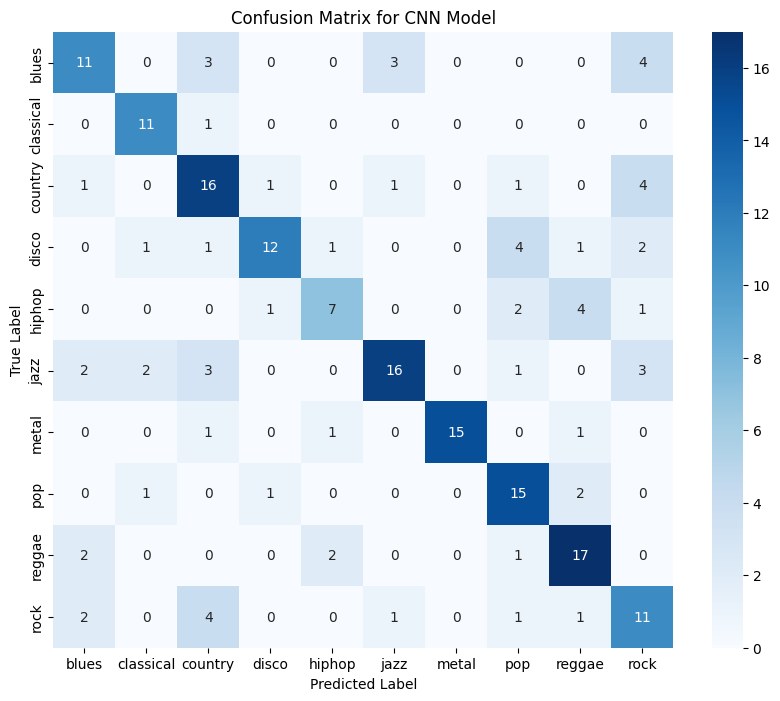

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=GENRES, yticklabels=GENRES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN Model')
plt.show()

In [21]:
print("Classification Report for custom CNN")
print(classification_report(y_test, y_pred, target_names=GENRES))

Classification Report for custom CNN
              precision    recall  f1-score   support

       blues       0.61      0.52      0.56        21
   classical       0.73      0.92      0.81        12
     country       0.55      0.67      0.60        24
       disco       0.80      0.55      0.65        22
      hiphop       0.64      0.47      0.54        15
        jazz       0.76      0.59      0.67        27
       metal       1.00      0.83      0.91        18
         pop       0.60      0.79      0.68        19
      reggae       0.65      0.77      0.71        22
        rock       0.44      0.55      0.49        20

    accuracy                           0.66       200
   macro avg       0.68      0.67      0.66       200
weighted avg       0.68      0.66      0.66       200



| Metric                   | **SVM Model**        | **CNN Model**    |
| ------------------------ | --------------------- | ----------------- |
| **Accuracy**             | **76.5%**             | 65.0%             |
| **Macro F1-score**       | **0.76**              | 0.66              |
| **Best Predicted Genre** | Classical (F1 = 0.93) | Metal (F1 = 0.91) |
| **Weakest Genre**        | Rock (F1 = 0.65)      | Rock (F1 = 0.49)  |
| **Confusion Matrix**     | Mostly clean 🔵       | More scattered 🔴 |

In [16]:
# Optional: Save model
model.save('genre_cnn_model.keras')